<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_2A_iso2mesh_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 2, Session 2A

## Session 2A: MMC and Iso2Mesh Training


# <font color='orange'>Step 0: Setting up MCX and Octave environments within Google Colab</font>

> **You must rerun all cells in Step 0 in appearance order when you start a new session, or after reconnect to a runtime**

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Jupyter Notebook via "magic command" `%load_ext oct2py.ipython`

<font color='green'>If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and verify if it has already selected "GPU"; if not, please select the T4 GPU.</font>

**Please note**: MCX/MCXLAB is GPU-accelerated. This notebook by default requests an NVIDIA GPU. Howevever, when you click on the run-button for the below section, your browser may fail to allocate a GPU runtime and ask you if you want to continue with a non-GPU runtime. If you choose to proceed without GPU support, you will have to run the [section immediately following the next section](#mcx_setup_opencl) to install OpenCL-based MCXLAB (called mcxlabcl) and utilize the CPU to run the rest of the tutorials. The OpenCL version of MCXLAB will work for all examples, but will be substentially slower to run (this tutorial also reduces the photon numbers accordingly to lower the runtime).

In [ ]:
#@title Init 1: Initial setup of environment for running MCXLAB (run the below section once)

# install octave and oct2py
! apt-get update && apt-get install octave octave-image jq libpocl2 pocl-opencl-icd libnvidia-compute-535   # install octave (a free matlab clone), jq and OpenCL runtimes
! python3 -m pip install oct2py jdata bjdata matplotlib plotly  # install oct2py, jdata, bjdata and matplotlib Python modules

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip MCXStudio
! rm -rf MCXStudio*
! curl https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip -O MCXStudio-linux-x86_64-nightlybuild.zip # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! cp -a "$PWD/MCXStudio/MCXSuite/mcx/bin/mcx" "$PWD"
! cp -a "$PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl" "$PWD"
! cp -a "$PWD/MCXStudio/MCXSuite/mmc/bin/mmc" "$PWD"
! cp -a "$PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex" "$PWD/MCXStudio/MATLAB/zmat/"

! mv "$PWD/MCXStudio/MCXWorkshop2024pyPlot" "$PWD"
! perl -pi -e 's/^plotmesh/%plotmesh/g' "$PWD/MCXStudio/MATLAB/brain2mesh/examples/SPM_example_brain.m"

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && mv "$PWD/mcxcl" "$PWD/mcx"
! ./mcx -L

### <font color='orange'>Init 2: Only need to run this once at the beginning</font>

In [ ]:
%%octave
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                 % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);  % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                 % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']); % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);               % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);             % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/redbird-m/matlab']);       % add path to redbird-m
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                   % add path to zmat for data compression
addpath([pwd filesep 'MCXStudio/MATLAB/hyperspectral_demo']);     % add path to hyperspectral_demo for exec 4

struct_levels_to_print(0);
print_struct_array_contents(0);

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

### <font color='orange'>Init 3: Verify your environments</font>

---

In [ ]:
%%octave
which mcx
which s2m
which zipmat

%mcxlab('gpuinfo')     % use this command to list supported CPU or GPU in octave
%unix('./mcx -L')        % use -L flag to list GPU in the command line

'mcx' is a function from the file /content/MCXStudio/MATLAB/mcxlab/mcx.mex

's2m' is a function from the file /content/MCXStudio/MATLAB/iso2mesh/s2m.m

'zipmat' is a function from the file /content/MCXStudio/MATLAB/zmat/zipmat.mex

# Iso2mesh Primer

Iso2Mesh is a compact, cross-platform 3-D mesh generation toolbox for MATLAB and GNU Octave.

Iso2Mesh has the following major strengths

- open-source, highly portable, cross-platform, works for MATLAB and Octave
- easy to automate with intuitive APIs
- 3-D image based surface and tetrahedral mesh generation
  - binary image (0-1 valued)
  - multi-labeled volume (integers, like mcx's volume)
  - gray-scale volume (floating-point values)
- easy-to-use: `vol2mesh`, `vol2surf`, `surf2mesh`, `surf2vol` ...
- advanced surface mesh processing: `surfboolean`, `smoothsurf`, `remeshsurf`, `meshcheckrepair`, `meshrefine` ...
- fast
- high-qaulity tetrahedral mesh generation based on quality metrics
- i2m GUI (matlab only)


![Iso2mesh workflow](https://iso2mesh.sourceforge.net/upload/iso2mesh_workflow_v2.png)


Iso2mesh offers comprehensive mesh generation, mesh processing and analysis functions, listed by groups below:

##### **shortcut**:
 `v2m,v2s,s2m,s2v,m2v,sms,i2m`
##### **main**:
 `vol2mesh,vol2surf,surf2mesh,surf2vol,mesh2vol,img2mesh`
##### **backend**:
 `binsurface,cgalv2m,cgals2m,vol2restrictedtri,surf2volz,mesh2mask`
##### **primitive**:
 `meshabox,meshasphere,meshanellip,meshunitsphere,meshacylinder,meshgrid5,meshgrid6,latticegrid,extrudecurve,meshcylinders`
##### **mesh inquery**:
 `finddisconnsurf,surfedge,volface,extractloops,meshconn,meshcentroid,nodevolume,elemvolume,neighborelem,layersurf,faceneighbors,edgeneighbors,maxsurf,flatsegment,orderloopedge,mesheuler,bbxflatsegment,surfplane,surfinterior,surfpart, surfseeds,meshquality,meshedge,meshface,surfacenorm,nodesurfnorm, uniqedges,uniqfaces,advancefront,innersurf,outersurf,surfvolume
insurface`
##### **meshfix**:
`meshcheckrepair,meshreorient,removedupelem,removedupnodes,removeisolatednode,removeisolatedsurf,surfaceclean,getintersecttri,delendelem,surfreorient`
##### **metch (mesh registration)**:
`proj2mesh,dist2surf,regpt2surf,affinemap,metchgui,metchgui_one`
##### **remesh**:
`meshresample,remeshsurf,smoothsurf,sortmesh,mergemesh,meshrefine,mergesurf,surfboolean,fillsurf,highordertet, elemfacecenter,barydualmesh,meshinterp,meshremap,extrudesurf`
##### **polyline**:
`slicesurf,slicesurf3,polylinelen,polylinesimplify,polylineinterp,closestnode`
##### **fileio**:
`saveasc,savedxf,savestl,savebinstl,saveinr,saveoff,savesmf,savesurfpoly,savegts,readgts,savemsh,savevrml,readasc,readinr,readmedit,readoff,readsmf,readtetgen,deletemeshfile,mcpath,mwpath,savemedit,savejson,loadjson,saveubjson,loadubjson,loadmsgpack,savemsgpack,savebj,loadbj,savemphtxt,savetetgenele,savetetgennode,saveabaqus, savenirfast,readnirfast,readnifti,readmptiff`
##### **jdata/JSON data loading/saving**:
`savejmesh,loadjnifti,savejnifti,loadnifti,savenifti,jdataencode,jdatadecode,jload,jsave,decodevarname,encodevarname,jnifticreate,nifticreate,nii2jnii,jnii2nii,niicodemap,niiformat,savebnii,savejnii`
##### **data compression**:
`zlibencode,zlibdecode,gzipencode,gzipdecode,lzmaencode,lzmadecode,lzipencode,lzipdecode,lz4encode,lz4decode,lz4hcencode,lz4hcdecode,base64decode,base64encode`
##### **binary image**:`bwislands,fillholes3d,deislands2d,deislands3d,ndgaussian,ndimfilter, imedge3d,internalpoint,smoothbinvol,thickenbinvol,thinbinvol,maskdist`
##### **plotting**:
`plotmesh,plotsurf,plottetra,plotedges,qmeshcut`
##### **misc**:
`surfdiffuse,volmap2mesh,isoctavemesh,getvarfrom,raytrace,linextriangle,getplanefrom3pt,getexeext,fallbackexeext,iso2meshver,raysurf,getoptkey,rotatevec3d,rotmat2vec,varargin2struct,jsonopt,mergestruct,orthdisk,nestbracket2dim,fast_match_bracket,match_bracket,memmapstream`

![iso2mesh main functions](https://iso2mesh.sourceforge.net/upload/iso2mesh_v1_functions.png)


## Creating meshes from simple shape primititves

---



The first thing to do is to list the usable GPU on your system. You should use `mcxlab('gpuinfo')`. If there is one or more GPU, you should see GPU information printed in the below cell.

maxvol = 100

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

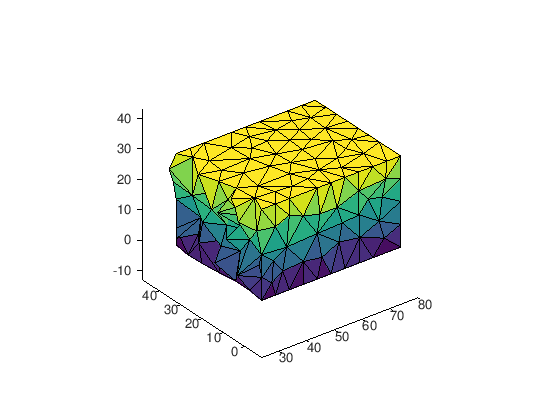

In [ ]:
%%octave

maxvol=100 # @param {type:"slider", min:4, max:200,step:1}

[node, face, elem] = meshabox([0,0,0], [80,40, 30], maxvol);

plotmesh(node, elem, 'x>30')

In [ ]:
%%octave -s 800,800

max_tet_volume=200 # @param {type:"slider", min:10, max:200,step:1}

[no,fc,seeds]=latticegrid([0 60], [0 50], [0, 5, 30]);

seeds

fc=cell2mat(fc);
trifc=[fc(:,[1 2 3]); fc(:,[1 3 4])];

figure(1)
subplot(211)
plotmesh(no, trifc);


[node, elem]=s2m(no, trifc, 1, max_tet_volume, 'tetgen', seeds);

subplot(212)
plotmesh(node, elem)
colorbar

## Creating meshes from Boolean operations of simple shapes


In [ ]:
%%octave -s 800,800

% ceate object 1: a 2-layer z-lattice

[no,fc,seeds]=latticegrid([0 60], [0 60], [0, 20, 50]);

radbound=2 # @param {type:"slider", min:2, max:10,step:1}
maxvol=100 # @param {type:"slider", min:4, max:200,step:1}
zcylinder=35 % @param {type:"slider", min:4, max:50,step:1}

fc=cell2mat(fc);
trifc=[fc(:,[1 2 3]); fc(:,[1 3 4])];

[nlayers, elayers, flayers]=s2m(no, trifc, 1, maxvol, 'tetgen', seeds);
size(nlayers)

[nlayers, flayers]=removeisolatednode(nlayers(:,1:3), flayers(:,1:3));
size(nlayers)

plotmesh(nlayers, flayers, 'y>10')


% ceate object 2: a cylinder


[ncyl,fcyl]=meshacylinder([30, -10, zcylinder],[30, 70, zcylinder], 10, radbound, maxvol,20);

[ncyl,fcyl]=removeisolatednode(ncyl(:,1:3),fcyl(:,1:3));

hold on
plotmesh(ncyl, fcyl)

set(gca, 'position', [0 0 1 1]);

`surfboolean(node1,face1, operator, node2,face2)` performs a boolean operation on two triangular surfaces (by calling [Cork](https://github.com/gilbo/cork) - a meshing utility).

The supported operators include the typical
- `'and'` (same as `'inter'`),
- `'or'` (same as `'union'`),
- `'diff'` (mesh1-mesh2), but also include more complex operators such as
- `'resolve'` (union of mesh1 and mesh2 but also include all interior surfaces),
- `'first'` (mesh1 plus portion of mesh2 inside of mesh1)
- `'second'` (mesh2 plus portion of mesh1 inside of mesh2)

for each of the above operator, a prepending `-` means the resulting mesh is post-processed with a remesh operation for more uniform triangles.

In [ ]:
%%octave -s 800,800

boolopt='first' # @param ['and','or','diff','first','second','resolve','-union','-resolve','-first','-second']

[no, fc]=surfboolean(nlayers, flayers, boolopt, ncyl, fcyl);

clf
plotmesh(no, fc, 'y>40 | y<20');
set(gca, 'position', [0 0 1 1]);

`s2m` is the shortcut to `surf2mesh`, which is a wrapper to the powerful mesh generation software Tetgen for converting water-tight surface models into high quality tetrahedral meshes.
```
[node,elem,face]=s2m(v,f,keepratio,maxvol,method,regions,holes)
```
the `regions` input of s2m allows users to specify seeds - a 3D coordinate within a surface compartment - to label each isolated compartment of the output tetrahedral mesh.

maxvol = 100

regionseeds =

   30   30   35

   30   30   10

   30   30   22

holeseeds = [](0x0)

method = tetgen1.5

generating tetrahedral mesh from closed surfaces ...

creating volumetric mesh from a surface mesh ...

volume mesh generation is complete

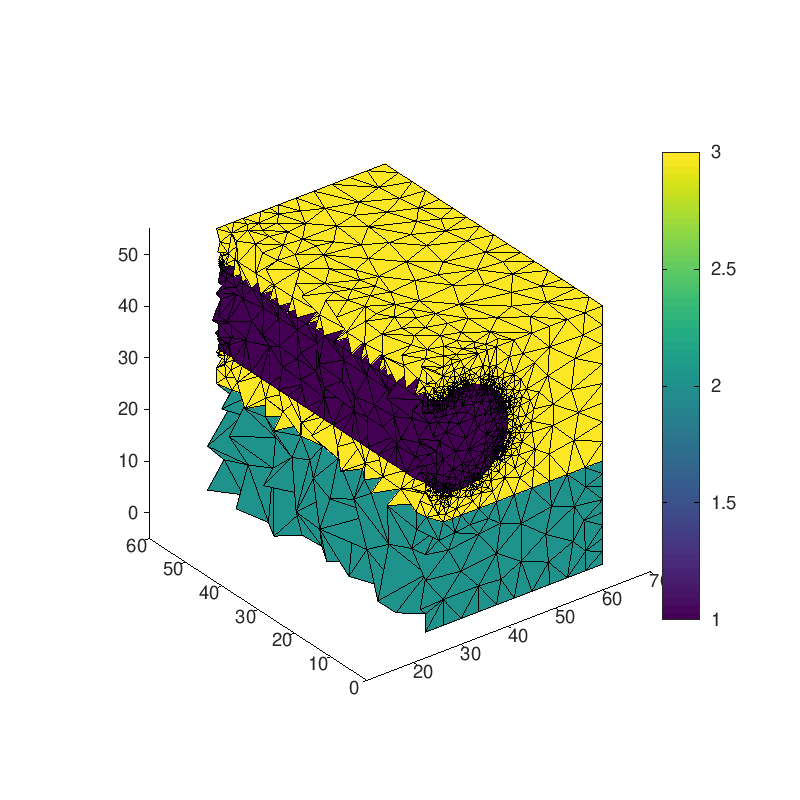

In [ ]:
%%octave -s 800,800

maxvol=100 # @param {type:"slider", min:4, max:200,step:1}
regionseeds=[30,30,35; 30,30,10; 30,30,22] # @param ['[]', '[30,30,35; 30,30,10; 30,30,22]'] {type: "raw"}
holeseeds=[] # @param ['[]', '[30,30,35]'] {type: "raw"}
method='tetgen1.5' # @param ['tetgen', 'tetgen1.5']

[node, elem]=s2m(no, fc, 1, maxvol, method, regionseeds, holeseeds);

plotmesh(node, elem, 'x>25')
colorbar

set(gca, 'position', [0 0 1 1]);

## Creating meshes from binary volumes

Image-based mesh-generation is one of the key features that Iso2Mesh offers.

In this mesh-generation workflow, the input data is a 3-D binary array, integer array, or floating point array. Iso2Mesh can efficiently extract isosurfaces from the volume and create complex mesh models.

Let's load a brain atlas (encoded in JSON) from NeuroJSON.io

https://neurojson.org/db/fieldtrip(atlas)/FieldTrip--AAL--AAL1



In [ ]:
%%octave -s 800,800

atlas = loadjson('https://neurojson.io:7777/fieldtrip(atlas)/FieldTrip--AAL--AAL1');
img = atlas.tissue;

size(img)
unique(img(:))'


% first, let's create a mesh of the entire brain: (img>0) is a binary volume

radbound=4 # @param {type:"slider", min:2, max:20,step:1}
maxvol=100 # @param {type:"slider", min:10, max:200,step:1}

[node, elem]=v2m(img>0, 0.5, radbound, maxvol);
node=node*2;

plotmesh(node, elem)

In [ ]:
%%octave -s 800,800

radbound=5 # @param {type:"slider", min:2, max:20,step:1}
maxvol=100 # @param {type:"slider", min:10, max:200,step:1}

[no, fc]=v2s(img>0, 0.5, radbound);
no=no*2;

[node, elem]=s2m(no, fc, 1, maxvol);

close all

plotmesh(node, elem, 'z<120')

when using the `cgalmesh` method with `v2m`, one can create multi-labeled mesh from a segmented volume (multi-labeled volume, similar to mcx's input volume).

In [ ]:
%%octave -s 800,800

img(img>60)=60;

radbound=10 # @param {type:"slider", min:10, max:30,step:1}
maxvol=100 # @param {type:"slider", min:10, max:200,step:1}

tic
[node, elem]=v2m(uint8(img), [], radbound, maxvol, 'cgalmesh');
toc

plotmesh(node, elem, 'z<120')

## High-quality head/brain mesh generation using Brain2Mesh

Brain2Mesh (https://mcx.space/brain2mesh) is a small script built upon the Iso2Mesh meshing pipeline.

Details please see

> Tran AP+, Yan S+, Fang Q*, (2020) [“Improving model-based fNIRS analysis using mesh-based anatomical and light-transport models,"](http://dx.doi.org/10.1117/1.NPh.7.1.015008) Neurophotonics, 7(1), 015008


Brain2mesh is rather a specialized Iso2Mesh processing pipeline for handling multi-layered embedded shells of closed surfaces, such as our brain.

In [ ]:
%%octave -s 800,800

b2mfolder=fileparts(which('brain2mesh'));

addpath([b2mfolder filesep 'examples']);

pkg load image  % load the
which imfill

which SPM_example_brain

% this will take about 4 min for brain mesh generation (brain2mesh call)
% 1 second for brain1020 calculations
% and another 1 min for rendering
%% wait until the end

SPM_example_brain

whos

In [ ]:
%%octave
tic
savejson('', struct('node', single(node), 'elem', uint32(elem), 'face', uint32(face)), 'filename', 'brainmesh.json', 'compression', 'zlib');
toc

Elapsed time is 4.12843 seconds.

In [ ]:
import jdata as jd

mesh=jd.load('brainmesh.json')
mesh['face'][:,0:3]-=1

print(mesh.keys())
print(mesh['node'].shape)
print(mesh['node'].dtype)
print(mesh['face'].shape)
print(mesh['face'].dtype)

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Mesh3d(
    x=mesh['node'][:, 0],
    y=mesh['node'][:, 1],
    z=mesh['node'][:, 2],
    i=mesh['face'][:, 0],
    j=mesh['face'][:, 1],
    k=mesh['face'][:, 2],
    color='cyan',
    opacity=0.5
))
fig.update_layout(xaxis_range=[0, 120])
fig.show()